# Classical feedforward and control flow

This guide demonstrates the functionality available in the Qiskit SDK for performing classical feedforward and control flow. These features are sometimes referred to collectively as "dynamic circuits." Classical feedforward refers to the ability to measure qubits in the middle of a circuit and perform additional quantum operations that depend on the measurement outcome. Qiskit supports four control flow constructs for classical feedforward, each implemented as a method on [`QuantumCircuit`](../api/qiskit/qiskit.circuit.QuantumCircuit). The constructs and their corresponding methods are:

- If statement - [`QuantumCircuit.if_test`](../api/qiskit/qiskit.circuit.QuantumCircuit#if_test)
- Switch statement - [`QuantumCircuit.switch`](../api/qiskit/qiskit.circuit.QuantumCircuit#switch)
- For loop - [`QuantumCircuit.for_loop`](../api/qiskit/qiskit.circuit.QuantumCircuit#for_loop)
- While loop - [`QuantumCircuit.while_loop`](../api/qiskit/qiskit.circuit.QuantumCircuit#while_loop)

Each of these methods returns a [context manager](https://docs.python.org/3/reference/datamodel.html#with-statement-context-managers) and is typically used in a `with` statement. In the rest of this guide, we will explain each of these constructs and how to use them.

<Admonition type="caution">
  There are some limitations of classical feedforward and control flow operations on quantum hardware that might impact your program. For more information, see [Hardware considerations and limitations for classical feedforward and control flow](/run/dynamic-circuits-considerations).
</Admonition>

## If statement

The if statement is used to conditionally perform operations based on the value of a classical bit or register.

In the example below, we apply a Hadamard gate to a qubit and measure it. If the result is 1, then we apply an X gate on the qubit, which has the effect of flipping it back to the 0 state. We then measure the qubit again. The resulting measurement outcome should be 0 with 100% probability.

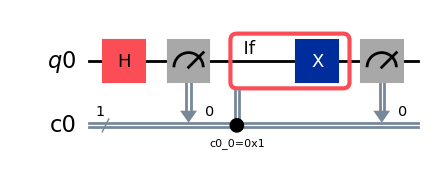

In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister

qubits = QuantumRegister(1)
clbits = ClassicalRegister(1)
circuit = QuantumCircuit(qubits, clbits)
(q0,) = qubits
(c0,) = clbits

circuit.h(q0)
circuit.measure(q0, c0)
with circuit.if_test((c0, 1)):
    circuit.x(q0)
circuit.measure(q0, c0)
circuit.draw("mpl")

# example output counts: {'0': 1024}

The `with` statement can be given an assignment target which is itself a context manager that can be stored and subsequently used to create an else block, which is executed whenever the contents of the if block are *not* executed.

In the example below, we initialize registers with two qubits and two classical bits. We apply a Hadamard gate to the first qubit and measure it. If the result is 1, then we apply a Hadamard gate on the second qubit; otherwise, we apply an X gate on the second qubit. Finally, we measure the second qubit as well.

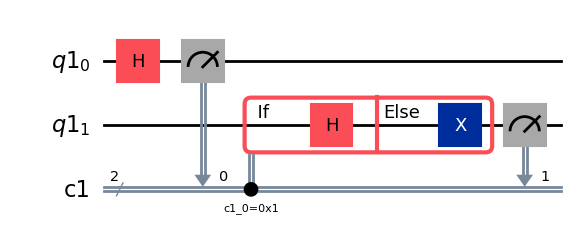

In [2]:
qubits = QuantumRegister(2)
clbits = ClassicalRegister(2)
circuit = QuantumCircuit(qubits, clbits)
(q0, q1) = qubits
(c0, c1) = clbits

circuit.h(q0)
circuit.measure(q0, c0)
with circuit.if_test((c0, 1)) as else_:
    circuit.h(q1)
with else_:
    circuit.x(q1)
circuit.measure(q1, c1)

circuit.draw("mpl")

# example output counts: {'01': 260, '11': 272, '10': 492}

In addition to conditioning on a single classical bit, it's also possible to condition on the value of a classical register composed of multiple bits.

In the example below, we apply Hadamard gates to two qubits and measure them. If the result is `01`, that is, the first qubit is 1 and the second qubit is 0, then we apply an X gate to a third qubit. Finally, we measure the third qubit. Note that for clarity, we chose to specify the state of the third classical bit, which is 0, in the if condition. In the circuit drawing, the condition is indicated by the circles on the classical bits being conditioned on. A black circle indicates conditioning on 1, while a white circle indicates conditioning on 0.

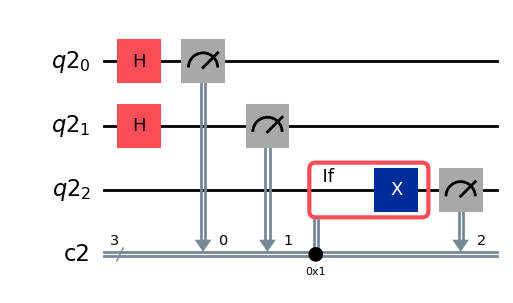

In [3]:
qubits = QuantumRegister(3)
clbits = ClassicalRegister(3)
circuit = QuantumCircuit(qubits, clbits)
(q0, q1, q2) = qubits
(c0, c1, c2) = clbits

circuit.h([q0, q1])
circuit.measure(q0, c0)
circuit.measure(q1, c1)
with circuit.if_test((clbits, 0b001)):
    circuit.x(q2)
circuit.measure(q2, c2)

circuit.draw("mpl")

# example output counts: {'101': 269, '011': 260, '000': 252, '010': 243}

## Switch statement

The switch statement is used to select actions based on the value of a classical bit or register. It is similar to an if statement, but allows one to specify more cases for the branching logic. In the example below, we apply a Hadamard gate to a qubit and measure it. If the result is 0, we apply an X gate on the qubit, and if the result is 1, we apply a Z gate. The resulting measurement outcome should be 1 with 100% probability.

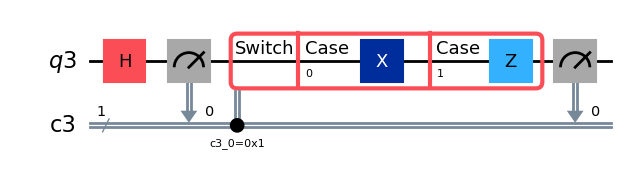

In [4]:
qubits = QuantumRegister(1)
clbits = ClassicalRegister(1)
circuit = QuantumCircuit(qubits, clbits)
(q0,) = qubits
(c0,) = clbits

circuit.h(q0)
circuit.measure(q0, c0)
with circuit.switch(c0) as case:
    with case(0):
        circuit.x(q0)
    with case(1):
        circuit.z(q0)
circuit.measure(q0, c0)

circuit.draw("mpl")

# example output counts: {'1': 1024}

Because the example above used a single classical bit, there were only two possible cases, so we could have achieved the same result using an if-else statement. The switch case is mainly useful when branching on the value of a classical register composed of multiple bits, as demonstrated in the following example. Here, we also show how to construct a default case, which is executed if none of the preceding cases are. Note that in a switch statement, only one of the blocks are ever executed. There is no fallthrough.

In the example below, we apply Hadamard gates to two qubits and measure them. If the result is either 00 or 11, we apply a Z gate to the third qubit. If the result is 01, we apply a Y gate. If none of the preceding cases matched, we apply an X gate. Finally, measure the third qubit.

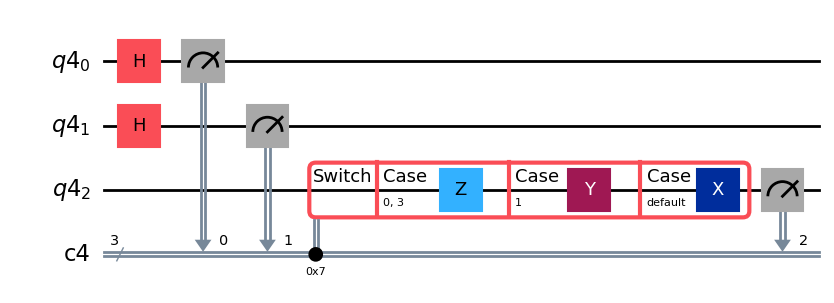

In [5]:
qubits = QuantumRegister(3)
clbits = ClassicalRegister(3)
circuit = QuantumCircuit(qubits, clbits)
(q0, q1, q2) = qubits
(c0, c1, c2) = clbits

circuit.h([q0, q1])
circuit.measure(q0, c0)
circuit.measure(q1, c1)
with circuit.switch(clbits) as case:
    with case(0b000, 0b011):
        circuit.z(q2)
    with case(0b001):
        circuit.y(q2)
    with case(case.DEFAULT):
        circuit.x(q2)
circuit.measure(q2, c2)

circuit.draw("mpl")

# example output counts: {'101': 267, '110': 249, '011': 265, '000': 243}

## For loop

A for loop is used to iterate over a sequence of classical values and perform some operations during each iteration.

In the example below, we use a for loop to apply 5 X gates to a qubit and then measure it. Because we perform an odd number of X gates, the overall effect is to flip the qubit from the 0 state to the 1 state.

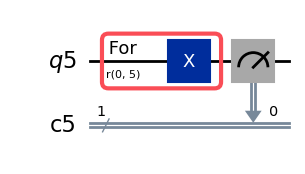

In [6]:
qubits = QuantumRegister(1)
clbits = ClassicalRegister(1)
circuit = QuantumCircuit(qubits, clbits)
(q0,) = qubits
(c0,) = clbits

with circuit.for_loop(range(5)) as _:
    circuit.x(q0)
circuit.measure(q0, c0)

circuit.draw("mpl")

# example output counts: {'1': 1024}

## While loop

A while loop is used to repeat instructions while some condition is satisfied.

In the example below, we apply Hadamard gates to two qubits and measure them. Then, we create a while loop that repeats this procedure while the measurement outcome is 11. As a result, the final measurement should never be 11, with the remaining possibilities appearing with approximately equal frequency.

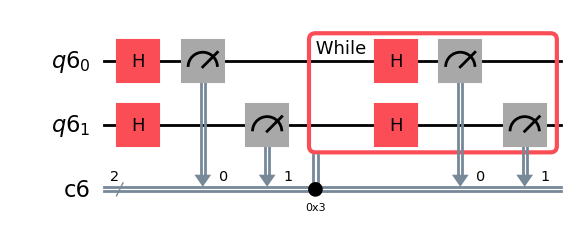

In [7]:
qubits = QuantumRegister(2)
clbits = ClassicalRegister(2)
circuit = QuantumCircuit(qubits, clbits)

q0, q1 = qubits
c0, c1 = clbits

circuit.h([q0, q1])
circuit.measure(q0, c0)
circuit.measure(q1, c1)
with circuit.while_loop((clbits, 0b11)):
    circuit.h([q0, q1])
    circuit.measure(q0, c0)
    circuit.measure(q1, c1)

circuit.draw("mpl")

# example output counts: {'01': 334, '10': 368, '00': 322}

## Next steps

<Admonition type="tip" title="Recommendations">
  -  See an example of dynamic circuits in the [Repeat until success](https://learning.quantum.ibm.com/tutorial/repeat-until-success) tutorial.
  -  Review the [circuit library API](/api/qiskit/circuit_library) reference.
</Admonition>